## [ISIC 2024 - Skin Cancer Detection with 3D-TBP](https://www.kaggle.com/competitions/isic-2024-challenge/overview)
##### Lingfeng (Ling) Su, Manal Amarsaikhan, Yuxin (Katy) Chen, Keelan Gan

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import os
from tensorflow.keras import layers, models



#### Dataset Summary Statistics

In [11]:
metadata = pd.read_csv(r"isic-2024-challenge\train-metadata.csv", low_memory=False)

print("---------------------------------------Shape-------------------------------------------------")
print(metadata.shape)
print("---------------------------------------Info--------------------------------------------------")
print(metadata.info())
print("---------------------------------------Describe----------------------------------------------")
print(metadata.describe())
print("---------------------------------------Missing Data------------------------------------------")
print(metadata.isnull().sum())

---------------------------------------Shape-------------------------------------------------
(401059, 55)
---------------------------------------Info--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A               

#### Class Distribution Before Processing

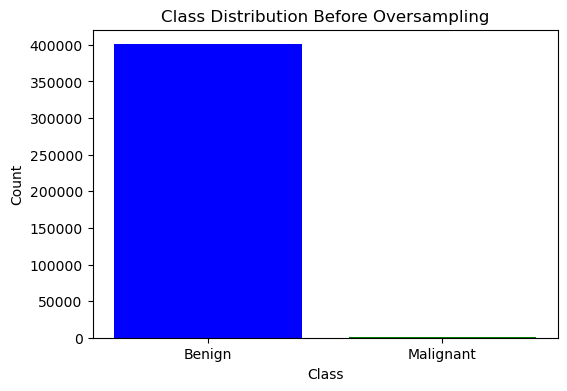

In [12]:
# Count class instances before oversampling
class_counts = metadata['target'].value_counts()

# Plot class distribution before oversampling
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling")
plt.show()

In [13]:
# Define numerical columns for outlier detection
numeric_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
    'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM', 'tbp_lv_deltaLBnorm',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max',
    'tbp_lv_symm_2axis'
]

# Compute Z-scores
z_scores = np.abs(stats.zscore(metadata[numeric_cols]))

# Set threshold (e.g., values greater than 3 std deviations)
threshold = 3
outliers_zscore = metadata[(z_scores > threshold).any(axis=1)]

print(f"Number of outliers detected using Z-Score: {len(outliers_zscore)}")

Number of outliers detected using Z-Score: 28234


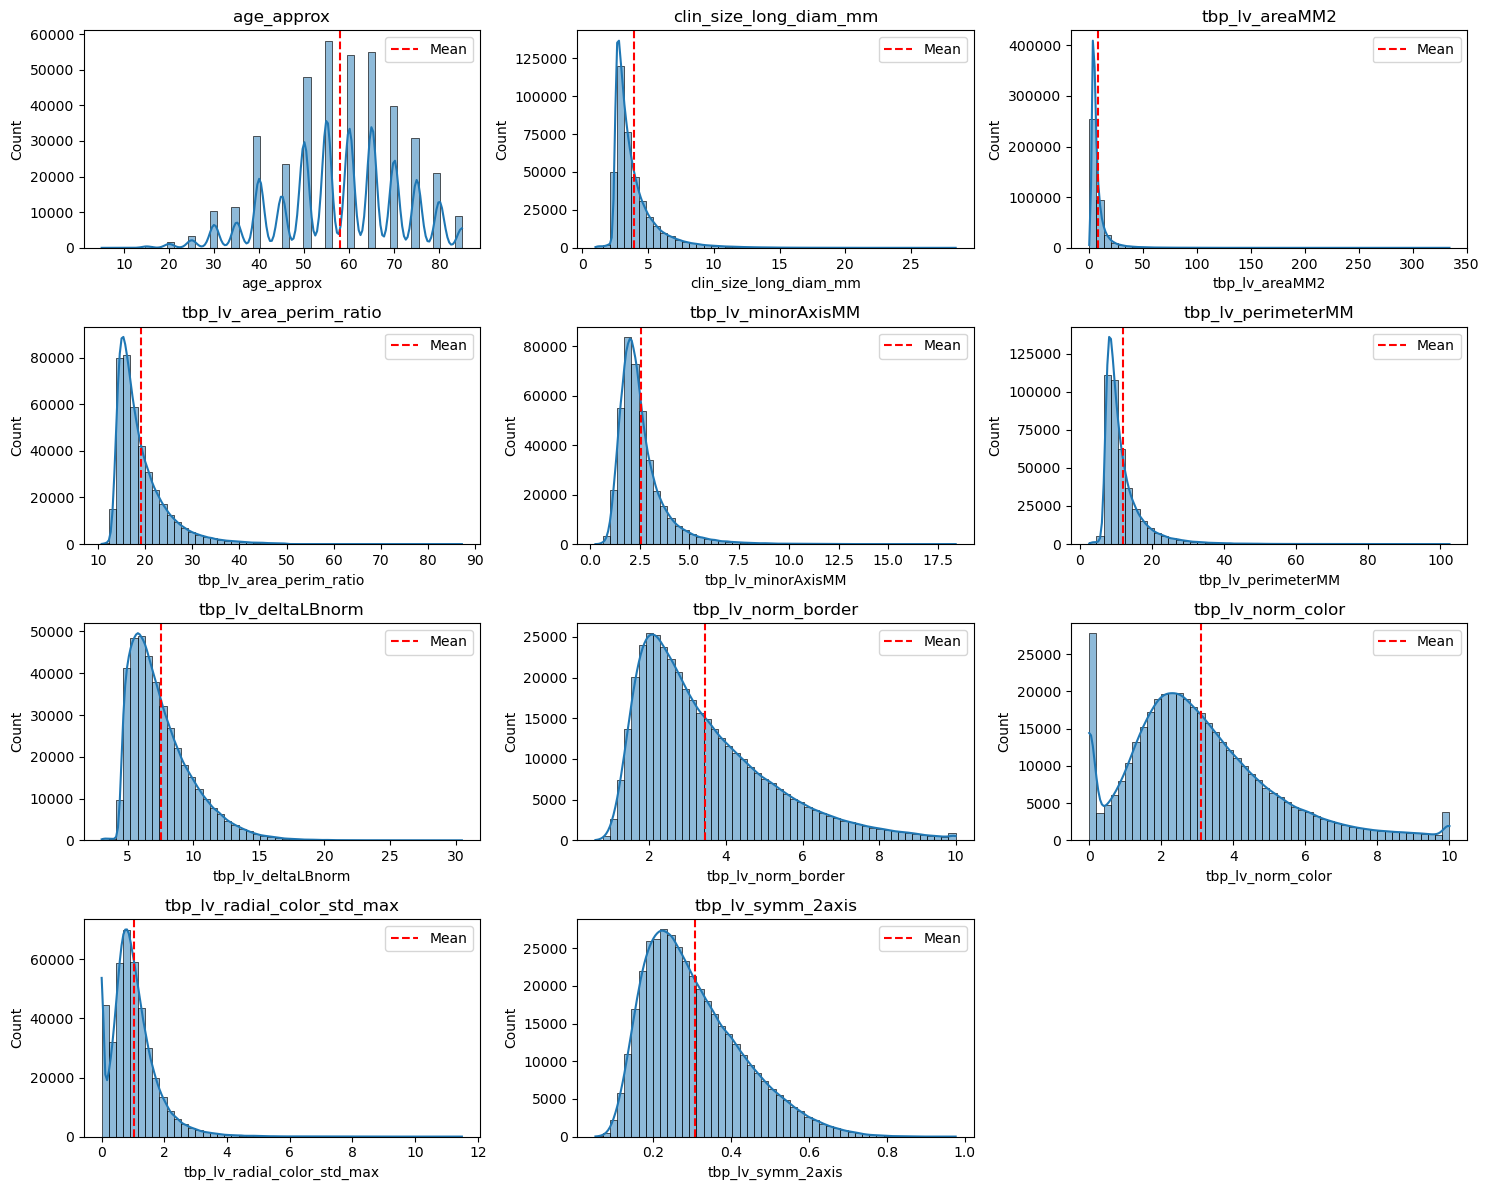

In [14]:
# Plot histograms for all selected numerical features
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)  # Adjust layout based on the number of features
    sns.histplot(metadata[col], bins=50, kde=True)
    plt.axvline(metadata[col].mean(), color='red', linestyle='dashed', label='Mean')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

#### Process Metadata

1. **Removed Unnecessary Columns**:
   - Dropped columns that are only relevant to training data or contain redundant information.
   - Columns removed: `lesion_id`, `iddx_2`, `iddx_3`, `iddx_4`, `iddx_5`, `mel_mitotic_index`, `mel_thick_mm`, `patient_id`, `image_type`, `tbp_tile_type`, `attribution`, `copyright_license`, `tbp_lv_dnn_lesion_confidence`, `iddx_1`, `iddx_full`.
        - `lesion_id`: Unique identifier with no predictive value.
        - `iddx_2`, `iddx_3`, `iddx_4`, `iddx_5`: Redundant or overly granular diagnostic classifications.
        - `mel_mitotic_index`, `mel_thick_mm`: Melanoma-specific features that may introduce bias.
        - `patient_id`: Unique identifier with no predictive value.
        - `image_type`, `tbp_tile_type`: Image normalization will be perfromed later.
        - `attribution`, `copyright_license`: Metadata related to image sourcing, not useful for prediction.
        - `tbp_lv_dnn_lesion_confidence`, `iddx_1`, `iddx_full`: These features are useful, but the safest approach is to train the model without these features, ensuring consistency between train and test datasets.
2. **Handled Missing Values**:
   - Removed rows with missing values in critical columns: `age_approx`, `anatom_site_general`, `sex`.
   - Ensured the dataset is complete and ready for further processing.

3. **Handled outliers**: For our dataset, we will handle outliers based on their impact and biological validity. 
    - Outliers in patient age (`age_approx`) are filtered if they are below 5 or above 100, as they are likely errors. 
    - For lesion size-related features (`clin_size_long_diam_mm`, `tbp_lv_areaMM2`, `tbp_lv_minorAxisMM`, `tbp_lv_perimeterMM`), we remove implausible values and apply Winsorization to cap extreme values at the 1st and 99th percentiles. 
    - Features related to lesion border irregularity, color variation, and asymmetry (`tbp_lv_norm_border`, `tbp_lv_norm_color`, `tbp_lv_radial_color_std_max`, `tbp_lv_symm_2axis`) may contain valuable diagnostic information, so instead of removing outliers, we apply Robust Scaling to reduce their influence. This approach ensures we retain meaningful patterns in the data while reducing the impact of extreme values.

3. **Separated Minority and Majority Classes**:
   - Split the dataset into minority class (`target = 1`) and majority class (`target = 0`).

4. **Shuffled the Dataset**:
   - Shuffled the dataset to ensure randomness and avoid bias during training. 

#### Key Insights
- The dataset will utilize class weights during model training to address the class imbalance, ensuring the model appropriately prioritizes the minority class.
- Irrelevant columns and missing values have been removed, ensuring data quality.
- The dataset is ready for further preprocessing and model training.

In [15]:
metadata = pd.read_csv(r"isic-2024-challenge\train-metadata.csv", low_memory=False)
# removed some columns included only in training data
metadata = metadata.drop(columns=['lesion_id', 'iddx_2', 'iddx_3','iddx_4','iddx_5','mel_mitotic_index','mel_thick_mm','tbp_lv_dnn_lesion_confidence', 'iddx_1', 'iddx_full'])
metadata = metadata.drop(columns=['patient_id','image_type','tbp_tile_type','attribution','copyright_license'])
# filter out data with missing values
metadata = metadata.dropna(subset=['age_approx', 'anatom_site_general', 'sex'])


# Define filtering thresholds for biologically implausible values
metadata = metadata[
    (metadata['age_approx'] >= 5) & (metadata['age_approx'] <= 100)
]
# Apply Winsorization to cap extreme values for lesion size-related features
size_cols = ['clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM']
for col in size_cols:
    metadata[col] = winsorize(metadata[col], limits=[0.01, 0.01])  # Cap at 1st and 99th percentile
# Apply RobustScaler to features where outliers may be informative
scale_cols = ['tbp_lv_area_perim_ratio', 'tbp_lv_deltaLBnorm', 'tbp_lv_norm_border', 
              'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max', 'tbp_lv_symm_2axis']
scaler = RobustScaler()
metadata[scale_cols] = scaler.fit_transform(metadata[scale_cols])

metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)

#### Class Distribution After Processing

In [16]:
metadata.head()

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,ISIC_7147422,0,40.0,female,posterior torso,3.00,24.029030,15.282590,44.048500,38.096760,...,0.383237,8.806065,-0.065106,3.674487,1.845194,-0.630193,30,-137.097800,1211.183000,144.318500
1,ISIC_1507281,0,65.0,male,upper extremity,3.55,16.568480,12.960110,24.118800,22.425760,...,0.305883,11.438010,0.541378,2.339820,1.597620,0.077003,0,-422.920200,1055.631000,19.795900
2,ISIC_6058560,0,60.0,male,lower extremity,6.37,13.028916,9.645184,23.861454,22.091742,...,-0.107049,19.936864,-0.216367,1.610065,1.640676,2.257810,85,208.417053,176.819626,84.927002
3,ISIC_1546058,0,55.0,female,lower extremity,6.99,15.376774,9.929800,25.938329,23.483679,...,1.456297,19.422157,1.250416,3.880231,2.199233,1.093100,120,220.242371,528.426453,10.920227
4,ISIC_3158974,0,70.0,female,lower extremity,5.21,20.070527,17.066881,24.714661,23.299075,...,-0.310480,18.647245,-1.142689,1.590689,2.857723,2.214430,155,120.173080,446.146454,28.172852


#### Image Sample With Properties

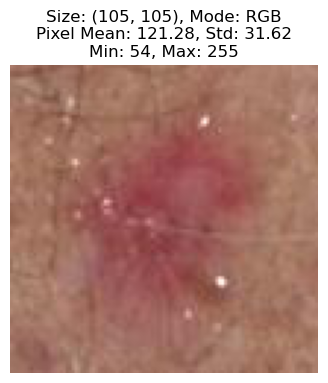

In [17]:
sample_image_path = r"isic-2024-challenge\train-image\image\ISIC_9996602.jpg"
img = Image.open(sample_image_path)

# Get image properties
image_size = img.size
image_mode = img.mode

# Convert image to numpy array for pixel statistics
img_array = np.array(img)
pixel_mean = img_array.mean()
pixel_std = img_array.std()
pixel_min = img_array.min()
pixel_max = img_array.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.title(f"Size: {image_size}, Mode: {image_mode}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Data Preprocessing Steps

##### 1. **Mapping Image Filenames to Labels**
- **Step**: Create a mapping from image filenames to labels using a dictionary.
- **Transformation**:
  - Append `.jpg` to `isic_id` to match image filenames.
  - Example: `isic_id = '12345'` → `'12345.jpg'`.
- **Purpose**: Align image filenames with their corresponding labels for further processing.

##### 2. **Splitting the Dataset**
- **Step**: Split the dataset into training (80%) and testing (20%) sets.
- **Transformation**:
  - Split minority and majority classes separately to maintain class distribution.
  - Use `train_test_split` with `test_size=0.2` and `random_state=42`.
- **Purpose**: Ensure the model is evaluated on a representative subset of the data.

##### 3. **Handling Class Imbalance**
- **Step**: Oversample the minority train class (`target = 1`) to address imbalance.
- **Transformation**:
  - Use `image_multiplier` to generate 30 augmented images per minority train class image.
  - Save augmented images in `processed_dir`.
  - Assign labels `1` to augmented images.
- **Purpose**: Balance the train dataset to prevent model bias toward the majority class.
- **Feature Engineering**:
  - Augmentation includes transformations like rotation, or scaling.

##### 4. **Creating TensorFlow Datasets**
- **Step**: Create TensorFlow datasets for training and testing sets.
- **Transformation**:
  - Use `tf.data.Dataset.from_tensor_slices` to create datasets from image paths and labels.
- **Purpose**: Enable efficient loading and preprocessing of data.

##### 5. **Parallelizing Image Loading and Preprocessing**
- **Step**: Apply `load_and_preprocess_image` to each image.
- **Transformation**:
  - Steps likely include:
    1. **Loading**: Load image from file path.
    2. **Resizing**: Resize to a consistent size (e.g., 100x100 pixels).
    3. **Normalization**: Normalize pixel values to [0, 1] or [-1, 1].
  - Use `map` with `num_parallel_calls=tf.data.experimental.AUTOTUNE` for parallel processing.
- **Purpose**: Ensure images are in a suitable format for training and improve processing speed.

##### 6. **Creating a Balanced Training Dataset**
- **Step**: Sample from minority and majority class datasets with predefined weights.
- **Transformation**:
  - Use tf.data.Dataset.sample_from_datasets to sample 10% from the minority class and 90% from the majority class.
  - Batch the combined dataset to process batch_size images at once.
- **Purpose**: Ensure each batch contains a balanced mix of minority and majority class samples.

#### Summary of Key Preprocessing Steps

| **Step**                          | **Description**                                                                 |
|------------------------------------|---------------------------------------------------------------------------------|
| **Mapping Filenames to Labels**    | Align image filenames with labels.                                              |
| **Splitting the Dataset**          | Split into training and testing sets while maintaining class balance.            |
| **Handling Class Imbalance**       | Oversample minority class using data augmentation.                              |
| **Creating TensorFlow Datasets**   | Create efficient datasets for loading and preprocessing.                        |
| **Parallelizing Preprocessing**    | Apply image loading and preprocessing in parallel.                              |
| **Batching**                       | Combine minority and majority class samples into balanced batches.              |

In [18]:
def load_and_preprocess_image(image_path, label):
    width, height = 100, 100
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    image = tf.image.resize(image, [width, height])
    image = image / 255.0
    
    return image, label

In [19]:
def image_multiplier(path, name, img, n):
    images = []
    for _ in range(n):
        tmp = img.copy()
        
        # random rotation
        angle = random.choice([90, 180, 270])
        tmp = tmp.rotate(angle, expand = True)
        
        # random brightness, contrast, and color
        brightness = random.uniform(0.8, 1.2)
        contrast = random.uniform(1, 1.2)
        color = random.uniform(1, 1.5)
        tmp = ImageEnhance.Brightness(tmp).enhance(brightness)
        tmp = ImageEnhance.Contrast(tmp).enhance(contrast)
        tmp = ImageEnhance.Color(tmp).enhance(color)
        
        # random orientation
        c = random.choice(['none', 'mirror', 'flip', 'mirror_flip'])
        if c == 'mirror':
            tmp = ImageOps.mirror(tmp)
        elif c == 'flip':
            tmp = ImageOps.flip(tmp)
        elif c == 'mirror_flip':
            tmp = ImageOps.mirror(tmp)
            tmp = ImageOps.flip(tmp)

        # random zoom
        scale = random.uniform(0.6, 1.5)
        tmpsize = (int(tmp.width * scale), int(tmp.height * scale))
        tmp = tmp.resize(tmpsize, Image.BICUBIC)

        # Save the image
        newname = name + str(random.randint(0, n)) + '.jpg'
        newpath = path + '/' + newname
        tmp.save(newpath)
        images.append(newpath)
    return images

In [20]:
# Create TensorFlow datasets
def create_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset

In [21]:
# Load metadata
image_dir = r"isic-2024-challenge\train-image\image"
processed_dir = r"isic-2024-challenge\processed_images"

# create DIR for run once use many times
os.makedirs(processed_dir, exist_ok=True)

# Create a mapping from image filenames to labels
labels = metadata[['isic_id', 'target']].copy()
labels['isic_id'] = labels['isic_id'].apply(lambda x: x + '.jpg')
image_to_label = dict(zip(labels['isic_id'], labels['target']))

# Create a list of image file paths and their corresponding labels
image_paths = [os.path.join(image_dir, img_id) for img_id in labels['isic_id']]
image_labels = [image_to_label[img_id] for img_id in labels['isic_id']]
new_labels = pd.DataFrame({'isic_id': image_paths, 'target': image_labels})

# Separate the minority and majority classes
minority_class = new_labels[new_labels['target'] == 1]
majority_class = new_labels[new_labels['target'] == 0]

# Split minority and majority classes into train and test sets (80-20 split)
minority_train, minority_test = train_test_split(minority_class, test_size=0.2, random_state=42)
majority_train, majority_test = train_test_split(majority_class, test_size=0.2, random_state=42)

# Reset indices
minority_train = minority_train.reset_index(drop=True)
minority_test = minority_test.reset_index(drop=True)
majority_train = majority_train.reset_index(drop=True)
majority_test = majority_test.reset_index(drop=True)

# Augment the minority class
n = 50
class_aug = pd.DataFrame(columns=['isic_id', 'target'])
for img_id in minority_train['isic_id']:
    img = Image.open(img_id)
    img_name = os.path.basename(img_id).split('.')[0]
    new_images = image_multiplier(processed_dir, img_name, img, n)
    new_labels = [1] * len(new_images)
    class_aug = pd.concat([class_aug, pd.DataFrame({'isic_id': new_images, 'target': new_labels})], ignore_index=True)


In [22]:
batch_size = 32
majority_ratio = 0.7
minority_ratio = 0.3

minority_train = pd.concat([minority_train, class_aug], ignore_index=True)
minority_train["target"] = minority_train["target"].astype(int)
# Training datasets
minority_train_dataset = create_dataset(minority_train['isic_id'], minority_train['target'])
majority_train_dataset = create_dataset(majority_train['isic_id'], majority_train['target'])

# Testing datasets
minority_test_dataset = create_dataset(minority_test['isic_id'], minority_test['target'])
majority_test_dataset = create_dataset(majority_test['isic_id'], majority_test['target'])

# Parallelize image loading and preprocessing
minority_train_dataset = minority_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_train_dataset = majority_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

minority_test_dataset = minority_test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_test_dataset = majority_test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

minority_train_dataset = minority_train_dataset.shuffle(buffer_size=1000)
majority_train_dataset = majority_train_dataset.shuffle(buffer_size=1000)

minority_train_dataset = minority_train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))
majority_train_dataset = majority_train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# Combine the minority and majority class train datasets
train_dataset = tf.data.Dataset.sample_from_datasets([minority_train_dataset, majority_train_dataset], weights=[minority_ratio, majority_ratio])
train_dataset = train_dataset.repeat().batch(batch_size)  # Ensure proper batching

# Combine the minority and majority class test datasets
# test_dataset = minority_test_dataset.concatenate(majority_test_dataset)
test_dataset = tf.data.Dataset.sample_from_datasets([minority_test_dataset, majority_test_dataset], weights=[minority_ratio, majority_ratio])
test_dataset = test_dataset.repeat().batch(batch_size)    # Batch the test dataset as well

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ images (InputLayer)             │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, 4, 4, 1408)     │     8,769,374 │
│ (EfficientNetV2Backbone)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,770,783 (33.46 MB)

 Trainable params: 8,688,495 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

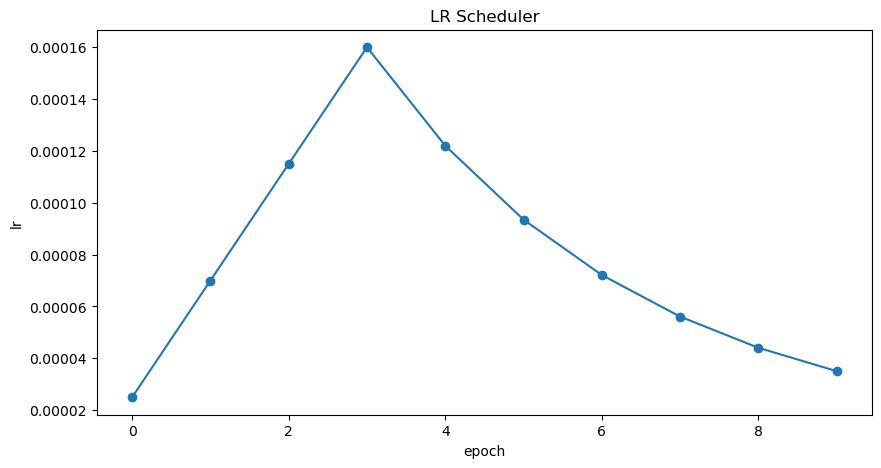

Epoch 1/10


C:\Users\flyin\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - auc: 0.6523 - loss: 1.3211 - val_auc: 0.7141 - val_loss: 0.5637 - learning_rate: 2.5000e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 919ms/step - auc: 0.9310 - loss: 0.9149 - val_auc: 0.8214 - val_loss: 0.3218 - learning_rate: 7.0000e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 909ms/step - auc: 0.9645 - loss: 0.5500 - val_auc: 0.8502 - val_loss: 0.2596 - learning_rate: 1.1500e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 934ms/step - auc: 0.9766 - loss: 0.4663 - val_auc: 0.8658 - val_loss: 0.2166 - learning_rate: 1.6000e-04
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 1000ms/step - auc: 0.9801 - loss: 0.4365 - val_auc: 0.8930 - val_loss: 0.2152 - learning_rate: 1.2200e-04
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - auc: 0.9799 - loss: 0.4320 - val_auc: 0.8952 - val_loss: 0.1812 - learning_rate: 9.3500e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - auc: 0.9861 - loss: 0.3727 - val_auc: 0.8935 - val_loss: 0.2031 

In [23]:
# Data augmentation
import keras
import keras_cv
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),  # Reduced rotation range
    layers.RandomZoom(0.2),  # Reduced zoom range
    layers.RandomContrast(0.1),  # Reduced contrast adjustment
    layers.RandomBrightness(0.1),  # Reduced brightness adjustment
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Reduced translation
])

image_input = keras.Input(shape=(100, 100, 3), name="images")
inp = {"images":image_input}

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b2_imagenet")
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(x1)

# Build model
model = keras.models.Model(inp, out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC()],
)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode="exp", plot=True)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)

es_cb = keras.callbacks.EarlyStopping(
    monitor="val_auc",   # Monitor validation AUC
    patience=3,          # Number of epochs with no improvement before stopping
    mode="max",          # Stop when 'val_auc' is no longer increasing
    restore_best_weights=True # Restore best weights when stopping
)

majority_weight = 1 / majority_ratio
minority_weight = 1 / minority_ratio
class_weights = {0: majority_weight, 1: minority_weight}

# Train the model with class weights
CNN_Model = model.fit(
    train_dataset,
    epochs=10,  # Increased number of epochs
    callbacks=[lr_cb, ckpt_cb, es_cb],
    steps_per_epoch=100,
    validation_data=test_dataset,
    validation_steps=50,  # Reduced validation steps for faster debugging
    verbose=1,
    shuffle=True,
    class_weight=class_weights,
)

In [24]:
# Print the first batch
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    

Images shape: (32, 100, 100, 3)
Labels shape: (32,)


#### Processed image with propertities

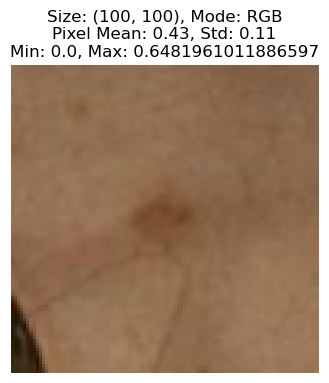

In [25]:
sample_image = images[1].numpy()

# Get image properties
image_size = sample_image.shape[:2]
image_mode = "RGB"

# Convert image to numpy array for pixel statistics
img_array = np.array(sample_image)
pixel_mean = img_array.mean()
pixel_std = img_array.std()
pixel_min = img_array.min()
pixel_max = img_array.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.axis("off")  # Hide axes
plt.title(f"Size: {image_size}, Mode: {image_mode}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Class Distribution per Batch After Processing

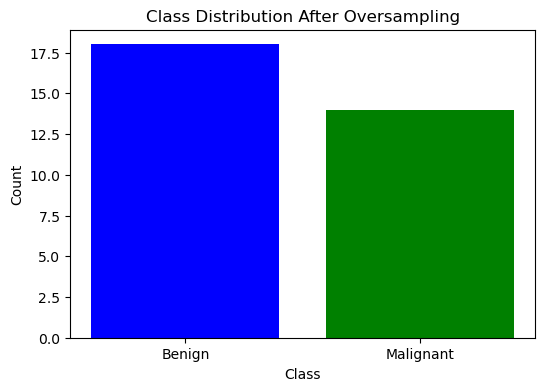

In [26]:
class_counts = np.bincount(labels.numpy())

plt.figure(figsize=(6, 4))
plt.bar([0, 1], class_counts, color=['blue', 'green'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution After Oversampling")
plt.show()

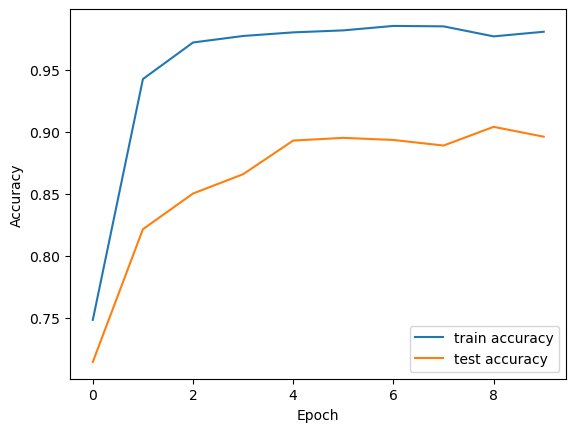

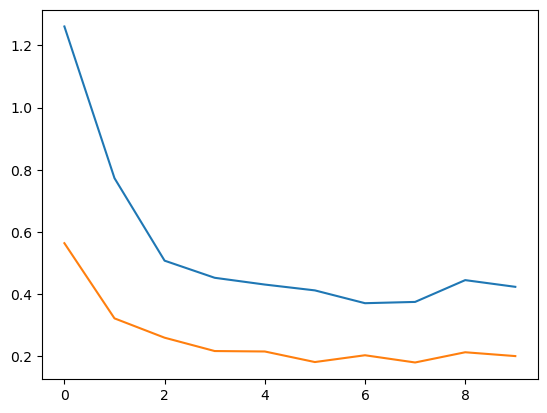

In [27]:
plt.plot(CNN_Model.history['auc'], label='train accuracy')
plt.plot(CNN_Model.history['val_auc'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

plt.plot(CNN_Model.history['loss'], label='train loss')
plt.plot(CNN_Model.history['val_loss'], label = 'test loss')

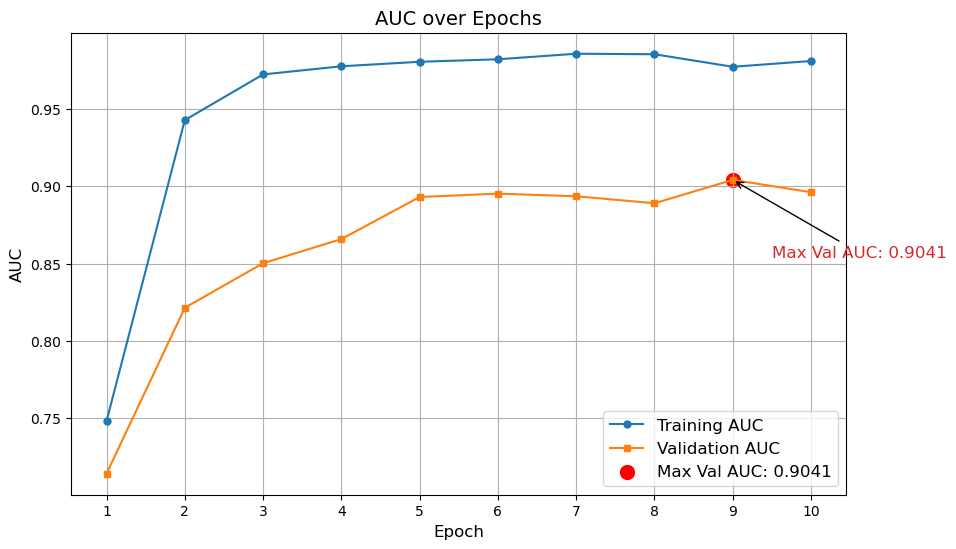

In [28]:
# Extract AUC and validation AUC from history
auc = CNN_Model.history['auc']
val_auc = CNN_Model.history['val_auc']
epochs = range(1, len(auc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, auc, 'o-', label='Training AUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC: {max_val_auc:.4f}', 
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

In [29]:
# Best Result
best_score = max(CNN_Model.history['val_auc'])
best_epoch = np.argmax(CNN_Model.history['val_auc']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best AUC: 0.90408
Best Epoch: 9
############################


In [30]:
model.load_weights("best_model.keras")

In [ ]:
import h5py
import cv2

# 1. Load metadata CSV
test_metadata = pd.read_csv('isic-2024-challenge/test-metadata.csv')

# Ensure `isic_id` is correctly sorted
test_metadata = test_metadata.sort_values(by="isic_id").reset_index(drop=True)

# Extract only `isic_id` (since `target` is not present in test set)
test_ids = test_metadata['isic_id']

# 1. Load and preprocess images from HDF5
test_images = []
TARGET_SHAPE = (100, 100)  # Adjust as per model's input shape

with h5py.File('isic-2024-challenge/test-image.hdf5', 'r') as h5_file:
    for isic_id in test_ids:  # Iterate over ordered test IDs
        byte_string = h5_file[isic_id][()]  # Extract image as byte string
        image_array = np.frombuffer(byte_string, np.uint8)  # Convert byte string to array
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)[..., ::-1]  # Convert BGR -> RGB

        # Resize image to match model input size
        image = cv2.resize(image, TARGET_SHAPE)

        test_images.append(image)

# Convert list to numpy array and normalize
test_images = np.array(test_images, dtype=np.float32) / 255.0

# 2. Run predictions
predictions = model.predict(test_images)  # Only pass images, no labels

# 3. Inspect predictions
print(predictions)



C:\Users\flyin\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(3, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.1956296 ]
 [0.00166319]
 [0.4608641 ]]


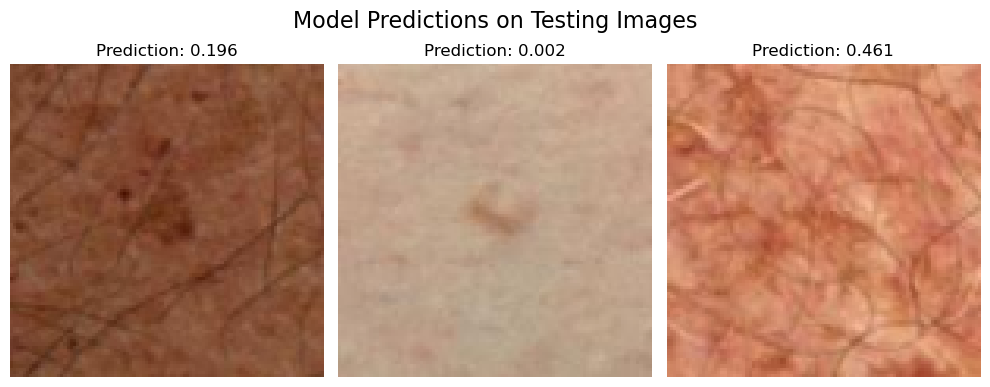

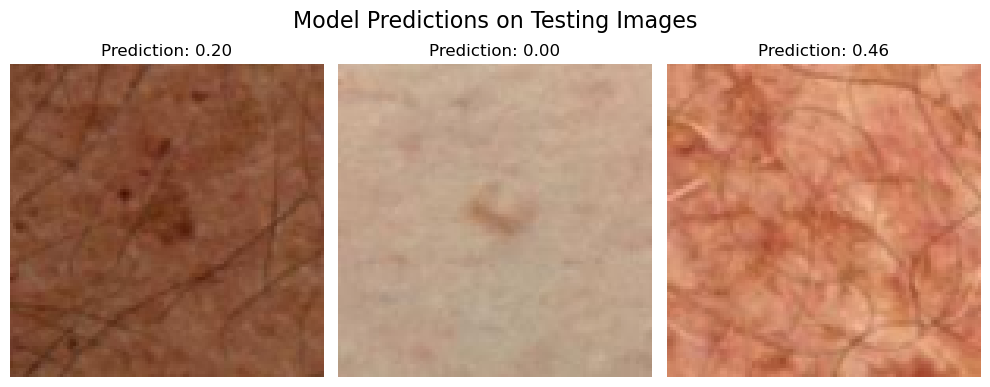

In [38]:
# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(test_images[i])  # Show image
    plt.title(f'Prediction: {predictions[i][0]:.3f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(test_images[i])  # Show image
    plt.title(f'Prediction: {predictions[i][0]:.2f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()

In [39]:
# We assume test_metadata has an "isic_id" column that identifies each sample.
pred_df = test_metadata[["isic_id"]].copy()
# Convert predictions to list format, ensuring the shape matches your submission requirements.
pred_df["target"] = predictions.tolist()

# Read the sample submission file (make sure BASE_PATH is defined or replace with your path)
BASE_PATH = 'path/to/your/submission/files'  # Update with your base path
sub_df = pd.read_csv(f'isic-2024-challenge/sample_submission.csv')
sub_df = sub_df[["isic_id"]].copy()

# Merge predictions with the submission dataframe on the "isic_id" column
sub_df = sub_df.merge(pred_df, on="isic_id", how="left")

# Save the final submission file
sub_df.to_csv("submission.csv", index=False)

# Optional: display the first few rows of the submission dataframe
print(sub_df.head())

        isic_id                   target
0  ISIC_0015657    [0.19562959671020508]
1  ISIC_0015729  [0.0016631853068247437]
2  ISIC_0015740     [0.4608640968799591]
